In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


2022-10-28 20:05:50.900954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 20:05:51.043457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 20:05:51.043481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 20:05:51.066768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 20:05:51.643187: W tensorflow/stream_executor/pla

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-10-28 20:05:52.225793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 20:05:52.264579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 20:05:52.264707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-28 20:05:52.264867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Samsung Webcam Data Pre-Processing

In [3]:
# Benign traffic

sw_benign = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_sw_benign = sw_benign.copy(deep=True)

columns = list(df_sw_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_sw_benign = pd.DataFrame(df_sw_benign, columns = chosen_columns)

# Bashlite

sw_bashlite_combo = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_combo = sw_bashlite_combo.copy(deep=True)
df_sw_bashlite_combo = pd.DataFrame(df_sw_bashlite_combo, columns = chosen_columns)

sw_bashlite_junk = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_junk = sw_bashlite_junk.copy(deep=True)
df_sw_bashlite_junk = pd.DataFrame(df_sw_bashlite_junk, columns = chosen_columns)

sw_bashlite_scan = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_scan = sw_bashlite_scan.copy(deep=True)
df_sw_bashlite_scan = pd.DataFrame(df_sw_bashlite_scan, columns = chosen_columns)

sw_bashlite_udp = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_udp = sw_bashlite_udp.copy(deep=True)
df_sw_bashlite_udp = pd.DataFrame(df_sw_bashlite_udp, columns = chosen_columns)

sw_bashlite_tcp = pd.read_csv('../nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_tcp = sw_bashlite_tcp.copy(deep=True)
df_sw_bashlite_tcp = pd.DataFrame(df_sw_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_sw_benign_norm = scaler.fit_transform(df_sw_benign)

df_sw_bashlitecombo_norm = scaler.fit_transform(df_sw_bashlite_combo)
df_sw_bashlitejunk_norm = scaler.fit_transform(df_sw_bashlite_junk)
df_sw_bashlitescan_norm = scaler.fit_transform(df_sw_bashlite_scan)
df_sw_bashliteudp_norm = scaler.fit_transform(df_sw_bashlite_udp)
df_sw_bashlitetcp_norm = scaler.fit_transform(df_sw_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [6]:
# Train set

len_benign = len(df_sw_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_sw_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_sw_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_bashlite_combo = df_sw_bashlitecombo_norm
X_test_bashlite_junk = df_sw_bashlitejunk_norm
X_test_bashlite_scan = df_sw_bashlitescan_norm
X_test_bashlite_tcp = df_sw_bashlitetcp_norm
X_test_bashlite_udp = df_sw_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

display(pd.DataFrame(X_train_VAE))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,9.813641e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.648563,0.384697
1,0.000000e+00,8.871585e-03,0.000000e+00,0.000000e+00,8.871585e-03,0.000000e+00,0.000000,0.008872,0.000000,0.005527,...,0.000000,9.813641e-01,0.000000e+00,0.000000,0.008872,0.000000,0.005527,0.000000,0.648563,0.384697
2,4.142870e-07,2.661461e-02,6.938495e-09,4.142870e-07,2.661461e-02,6.938495e-09,0.000000,0.026615,0.000000,0.016581,...,0.000000,9.813641e-01,0.000000e+00,0.000000,0.026615,0.000000,0.016581,0.000000,0.648563,0.384697
3,0.000000e+00,2.324355e-01,0.000000e+00,0.000000e+00,2.324355e-01,0.000000e+00,0.000000,0.232436,0.000000,0.144809,...,0.000000,9.175993e-09,0.000000e+00,0.000000,0.232436,0.000000,0.144809,0.000000,0.648563,0.384697
4,3.954166e-02,2.384001e-01,7.483999e-05,3.954166e-02,2.384001e-01,7.483999e-05,0.039581,0.238400,0.008651,0.148525,...,0.039581,4.050212e-09,8.255048e-17,0.122889,0.238400,0.008651,0.148525,0.000075,0.648563,0.384697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36500,1.894181e-02,3.877498e-02,7.977751e-03,1.894181e-02,3.877498e-02,7.977751e-03,0.018961,0.038775,0.089318,0.083096,...,0.018961,5.352919e-09,2.865085e-16,0.058868,0.038775,0.089318,0.083096,0.007978,0.648563,0.384697
36501,1.914497e-09,1.454940e-09,4.513472e-10,1.914497e-09,1.454940e-09,4.513472e-10,0.000000,0.000000,0.000000,0.013736,...,0.000000,1.949064e-08,0.000000e+00,0.000000,0.000000,0.000000,0.013736,0.000000,0.648563,0.384697
36502,0.000000e+00,3.273615e-01,0.000000e+00,0.000000e+00,3.273615e-01,0.000000e+00,0.000000,0.327361,0.000000,0.203949,...,0.000000,1.953782e-08,0.000000e+00,0.000000,0.327361,0.000000,0.203949,0.000000,0.648563,0.384697
36503,5.036143e-02,3.451082e-01,8.438171e-04,5.036143e-02,3.451082e-01,8.438171e-04,0.050411,0.345108,0.029049,0.215005,...,0.050411,9.757854e-09,3.827520e-16,0.156515,0.345108,0.029049,0.215005,0.000844,0.648563,0.384697


In [7]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [8]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

learning_rate = 0.0001 
epochs = 150
batch_size = 32
anomaly_threshold = 0.05
number_features = 23

In [9]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [10]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [11]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [12]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 36505 samples
Epoch 1/382


2022-10-28 20:09:26.953641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-28 20:09:26.984612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


36505/36505 [==============================] - 1s 31us/sample - loss: 10.0553
Epoch 2/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.9413
Epoch 3/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.8337
Epoch 4/382
36505/36505 [==============================] - 1s 22us/sample - loss: 3.8445
Epoch 5/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.7707
Epoch 6/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.7342
Epoch 7/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.7141
Epoch 8/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.6573
Epoch 9/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.6863
Epoch 10/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.6010
Epoch 11/382
36505/36505 [==============================] - 1s 23us/sample - loss: 3.6905
Epoch 12/382
36505/36505 [====

36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 177/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 178/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 179/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 180/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 181/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 182/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 183/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 184/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 185/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 186/382
36505/36505 [==============================] - 1s 23us/sample - loss: nan
Epoch 187/382
36505/36505 [===================

36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 363/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 364/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 365/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 366/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 367/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 368/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 369/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 370/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 371/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 372/382
36505/36505 [==============================] - 1s 21us/sample - loss: nan
Epoch 373/382
36505/36505 [===================

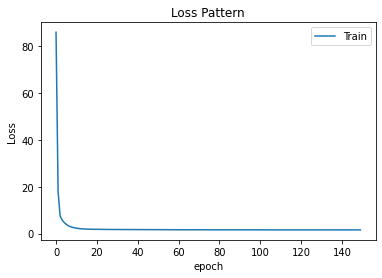

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
#np.quantile(error_vector, anomaly_threshold)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.05


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 9.988293647766113
[False False False ...  True  True  True]


0.9549742115099036

In [15]:
print(len(X_test_VAE))

338717


## Metrics

In [16]:
sys.stdout = open("../Results/samsung_webcam.txt", "a")

print(" ==== Test " + str(number_features) + " features ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'